# Practical Deep Learning Workshop - Assignment 2 - Predict Future Sales
----
### *Roy Levy - 313577611 & Yuval Sabag - 205712151<br> Group_Name - BGU-DL-TheRegressors*

----
### In the following notebook we will represent few models for solving the problem of the kaggle [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview) competition.<br><br>We are given a daily historical data about sales in several store.<br>Our goal is to predict on a test dataset what will be the amount of purchases of a product in every store.

## Loading the Data & Data Exploration
----
### First we will start by giving the reader a basic knowledge about the data we are dealing with.<br>The following statements show how the data is stored in the given files by the kaggle competition:
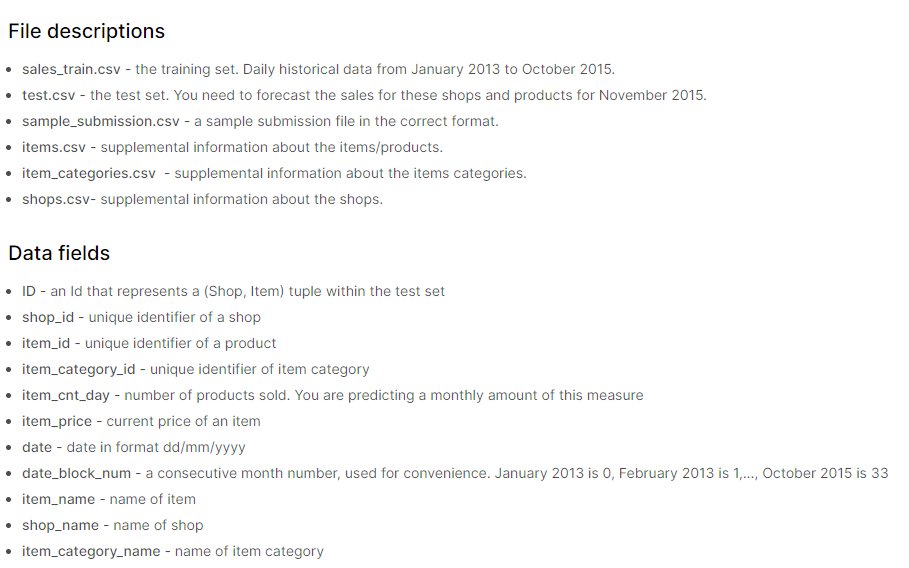
### We can see that a-lot of features were given to us, this allows us to perform different approches to build our models.<br><br> Let's start by loading our data!

## Loading the Data
----

In [ ]:
# imports and essentials
import tensorflow as tf
import numpy as np
import pandas as pd 
import random
from matplotlib import pyplot as plt
from IPython.display import display 
%matplotlib inline

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

In [ ]:
# read the data into pandas DataFrames
train_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
test_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').drop('ID',axis = 1)

In [ ]:
print("train_data shape: " + str(train_data.shape))
print("items shape: " + str(items.shape))
print("categories shape: " + str(categories.shape))
print("shops shape: " + str(shops.shape))
print("test_data shape: " + str(test_data.shape))

In [ ]:
# aggregate train_data monthly
train_data = train_data[train_data['item_cnt_day'] > 0]
train_data['daily_rev'] = train_data['item_price'] * train_data['item_cnt_day']
train_data = train_data.groupby(['date_block_num','shop_id','item_id'],axis=0).agg({'item_cnt_day':'sum','daily_rev':'sum'}).reset_index()
train_data.columns = ['date_block_num','shop_id','item_id','item_shop_cnt','item_shop_rev']

In [ ]:
train_data.head(15)

In [ ]:
def expand_train_data(train_data):
    from itertools import product
    num_months = 34

    expanded = []
    cols = ['date_block_num','shop_id','item_id']
    for i in range(num_months):
        sales = train_data[train_data['date_block_num'] == i]
        expanded.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique()))))    
    expanded = pd.DataFrame(np.vstack(expanded), columns=cols)
    train_data = pd.merge(expanded, train_data, on=cols, how='left')
    return train_data

In [ ]:
train_data = expand_train_data(train_data)
train_data

In [ ]:
# plotting revenue per month for the store 24
shop_id = 24
plt.figure()
train_data[train_data['shop_id'] == shop_id].fillna(0).groupby(train_data['date_block_num']).agg({'item_shop_rev': 'sum'}).reset_index()['item_shop_rev'].plot(kind="bar", figsize=(20,10), color=plt.cm.nipy_spectral(np.linspace(0, 1, 34)))
plt.xlabel("Month ID",fontsize=20)
plt.ylabel("Revenue Per Month(10^6)",fontsize=20)
plt.title("Revenue Per Month - Store ID: 24",fontsize=24)
plt.show()

### We can see that months 11 and 23 which corrolates for month 'November'(in different years) has a peak in the sales.<br>We assume that because it is a russian sales company that during this time of year the new year and the holidays are coming so more people purchase items for gifts.

In [ ]:
# plotting items bought per month for the store 24
shop_id = 24
plt.figure()
train_data[train_data['shop_id'] == shop_id].fillna(0).groupby(train_data['date_block_num']).agg({'item_shop_cnt': 'sum'}).reset_index()['item_shop_cnt'].plot(kind="bar", figsize=(20,10), color=plt.cm.brg(np.linspace(0, 1, 34)))
plt.xlabel("Month ID",fontsize=20)
plt.ylabel("Items Bought Per Month",fontsize=20)
plt.title("Items Bought Per Month - Store ID: 24",fontsize=24)
plt.show()

## Data preprocessing and preperation
----

### We are going to add the following non-categorical features:
1. total sales in previous month based on item_id.
2. total sales in previous month based on shop_id.
3. total sales in previous month.

### this features will become handy in next chapter when we will try to improve our embedding model.

In [ ]:
# adding the test data to our data
test_data['date_block_num'] = 34
keys = ['date_block_num','shop_id','item_id']
train_data = pd.concat([train_data, test_data], ignore_index=True, sort=False,keys=keys)

In [ ]:
train_data['item_shop_cnt'] = train_data['item_shop_cnt'].clip(0,20)
train_data['cnt_per_month'] = train_data['item_shop_cnt']
train_data = train_data.fillna(0)

In [ ]:
# We are going to merge our data with previous month salse
next_month_features = ['date_block_num','shop_id','item_id',
                      'item_shop_cnt','item_shop_rev']
merge_month_features = ['date_block_num','shop_id','item_id']

next_month = train_data[next_month_features].copy()
next_month['date_block_num'] += 1
train_data = train_data.drop(['item_shop_cnt','item_shop_rev'], axis=1)
train_data = pd.merge(train_data, next_month,
                     on=merge_month_features,
                     how='left').fillna(0)

In [ ]:

train_data  = train_data.rename(columns={'item_shop_cnt' : 'item_shop_cnt_prev_mo',
                                        'item_shop_rev': 'item_shop_rev_prev_mo'})
train_data

In [ ]:
# adding category feature
train_data = pd.merge(train_data, items[['item_id','item_category_id']],on=['item_id'])
train_data

In [ ]:
# adding actual month
train_data['month'] = train_data['date_block_num'] % 12
train_data

In [ ]:
# adding previous month sales of each item(how many times the item was purchased in the last month)
last_month_item_count = train_data.groupby(['date_block_num','item_id'],axis=0).agg({'item_shop_cnt_prev_mo': 'sum'}).reset_index()
last_month_item_count = last_month_item_count.rename(columns={'item_shop_cnt_prev_mo': 'sales_item_prev_month'})
train_data = pd.merge(train_data,last_month_item_count)
train_data

In [ ]:
# add all sales in a month
all_sales = train_data.groupby(['date_block_num'],axis=0).agg({'item_shop_cnt_prev_mo': 'sum'}).reset_index()
all_sales = all_sales.rename(columns={'item_shop_cnt_prev_mo': 'all_sales_perv_month'})
train_data = pd.merge(train_data,all_sales)
train_data

In [ ]:
# adding previous month sales of each shop
last_month_item_count = train_data.groupby(['date_block_num','shop_id'],axis=0).agg({'item_shop_cnt_prev_mo': 'sum'}).reset_index()
last_month_item_count = last_month_item_count.rename(columns={'item_shop_cnt_prev_mo': 'sales_shop_prev_month'})
train_data = pd.merge(train_data,last_month_item_count)
train_data

In [ ]:
# saving our final data in right formats

types = {'date_block_num' : np.int8,
        'shop_id' : np.int8,
        'item_id' : np.int16,
        'cnt_per_month' : np.int32,
        'item_shop_cnt_prev_mo' : np.int32,
        'item_shop_rev_prev_mo' : np.float64,
        'item_category_id' : np.int8,
        'month' : np.int8,
        'sales_item_prev_month' : np.int32,
        'all_sales_perv_month' : np.int32,
        'sales_shop_prev_month' : np.int32}

train_data = train_data.fillna(0)
train_data = train_data.astype(types)

## Building Classic ML benchmark - DecisionTreeRegressor
----
### In the following code we are going to pass our data into a DecisionTreeRegressor in order to get a solid benchmark score for our predictions.

In [ ]:
import pickle
train_data.to_pickle('data.pkl')
test_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').drop('ID',axis = 1)

In [ ]:
# creating our train data
X_train = train_data[train_data['date_block_num'] < 33]
X_train = X_train.drop(['cnt_per_month'],axis=1)
y_train = train_data[train_data['date_block_num'] < 33]['cnt_per_month']

# creating our validation data
X_val = train_data[train_data['date_block_num'] == 33]
X_val = X_val.drop(['cnt_per_month'],axis=1)
y_val = train_data[train_data['date_block_num'] == 33]['cnt_per_month']

# creating our test data
X_test = train_data[train_data['date_block_num'] == 34]
X_test = X_test.drop(['cnt_per_month'],axis=1)
X_test = pd.merge(test_data,X_test, on=['item_id','shop_id'],right_index=True).sort_index()
cols = X_train.columns
X_test = X_test[cols]

In [ ]:
# our benchmark model - DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
# fit the model on the train set
dt.fit(X_train,y_train)

In [ ]:
# calculate RMSE for our validation data
y_pred_val = dt.predict(X_val)
print("RMSE for validation set is: "+str(rmse(y_val,y_pred_val)))

In [ ]:
def submit_to_kaggle(index, y_test,title):
    submission = pd.DataFrame({
        "ID": index, 
        "item_cnt_month": y_test
    })
    submission.to_csv(title, index=False)

In [ ]:
# submitting scores to kaggle
y_test = dt.predict(X_test).clip(0,20)
index = X_test.index
submit_to_kaggle(index,y_test,"decision_tree_benchmark.csv")

### *We got a RMSE score of : 1.52793*

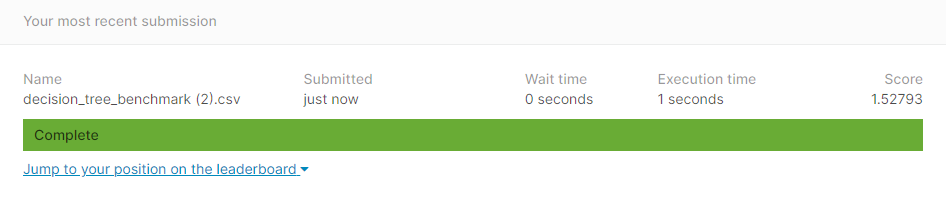
<br> 
### *Note: We will show leaderboard only for best result since that's the way kaggle saves the results*

## Building Categorical Embedding Model
----
### In this chapter we are going to use categorical embeddings in order to improve our model.<br> We will build a NN model with Embeddings layers.

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, concatenate, Dense, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.metrics import RootMeanSquaredError

In [ ]:
def plot_accuracy_vs_loss(history):
  # from lecture no.2

  fig, ax = plt.subplots(1,2,figsize=(12,4))
  ax[0].plot(history.history['root_mean_squared_error'])
  ax[0].plot(history.history['val_root_mean_squared_error'])
  ax[0].set_title('Model accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
def get_embedding_layer(shape,inp_len,reg,is_fe=False,weights=[]):
    emb = (Embedding(shape[0],shape[1],input_length=inp_len,embeddings_regularizer=l2(reg))) if not is_fe else (Embedding(shape[0],shape[1],input_length=inp_len,embeddings_regularizer=l2(reg),weights=weights))
    return emb
def get_shape_for_embedding(X):
    X_shp = X.shape[0]
    return (X_shp,int(np.sqrt(X_shp)))

In [ ]:
input_month = Input(shape=(1,), dtype='int64')
input_shop = Input(shape=(1,), dtype='int64')
input_category = Input(shape=(1,), dtype='int64')
input_item = Input(shape=(1,), dtype='int64')

In [ ]:
cat_features = ['month','shop_id','item_category_id','item_id']
X_train_cat = X_train[cat_features]
X_val_cat = X_val[cat_features]
X_test_cat = X_test[cat_features]

In [ ]:
months_shape = (12,4)
shops_shape = get_shape_for_embedding(shops)
cats_shape = get_shape_for_embedding(categories)
items_shape = get_shape_for_embedding(items)

months_emb_cat = get_embedding_layer(months_shape,1,1e-5)(input_month)
shops_emb_cat = get_embedding_layer(shops_shape,1,1e-5)(input_shop)
cats_emb_cat = get_embedding_layer(cats_shape,1,1e-5)(input_category)
items_emb_cat = get_embedding_layer(items_shape,1,1e-5)(input_item)

In [ ]:
x =  concatenate([months_emb_cat,shops_emb_cat,cats_emb_cat,items_emb_cat])
x = Flatten()(x)
x = Dense(1,activation='relu')(x)

model_embedding_cat = Model([input_month,input_shop,input_category,input_item],x)
model_embedding_cat.compile(loss = 'mse',optimizer='RMSProp', metrics=[RootMeanSquaredError()])
model_embedding_cat.summary()

In [ ]:
hist_emb = model_embedding_cat.fit([X_train_cat['month'],X_train_cat['shop_id'],X_train_cat['item_category_id'],X_train_cat['item_id']],
                       y_train,
                       epochs=6,
                       validation_data=[[X_val_cat['month'],X_val_cat['shop_id'],X_val_cat['item_category_id'],X_val_cat['item_id']],y_val],
                       batch_size = 4096,
                       shuffle=True)
plot_accuracy_vs_loss(hist_emb)

In [ ]:
# submitting scores to kaggle
y_test_cat = model_embedding_cat.predict([X_test_cat['month'],X_test_cat['shop_id'],X_test_cat['item_category_id'],X_test_cat['item_id']]).clip(0,20)
index = X_test_cat.index
submit_to_kaggle(index,y_test_cat.ravel(),"model_embedding_0.csv")

### *We got a RMSE score of : 1.58954*
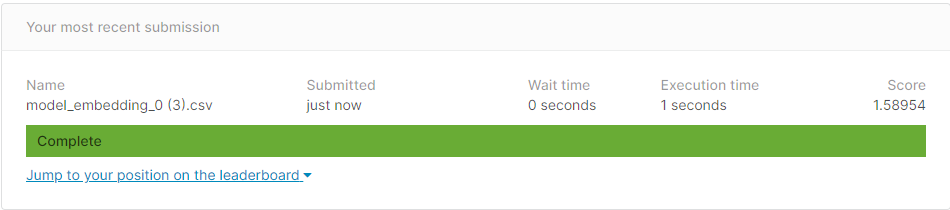

## Building Better Categorical Embedding Model
----
### In this chapter we will try to improve our previous embedding model.
* We will make our network even deeper by adding extra layers and we will try to use normalization and dropouts in order to reach better results.
* In the next attempt we will add the non-categorical features we added previously and create another model.

### Improved Categorical Embedding Model - version 0
----

In [ ]:
x =  concatenate([months_emb_cat,shops_emb_cat,cats_emb_cat,items_emb_cat])
x = Flatten()(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(1,activation='relu')(x)

model_embedding_cat_1 = Model([input_month,input_shop,input_category,input_item],x)
model_embedding_cat_1.compile(loss = 'mse',optimizer='RMSProp', metrics=[RootMeanSquaredError()])
model_embedding_cat_1.summary()

In [ ]:
hist_emb_1 = model_embedding_cat_1.fit([X_train_cat['month'],X_train_cat['shop_id'],X_train_cat['item_category_id'],X_train_cat['item_id']],
                       y_train,
                       epochs=6,
                       validation_data=[[X_val_cat['month'],X_val_cat['shop_id'],X_val_cat['item_category_id'],X_val_cat['item_id']],y_val],
                       batch_size = 4096,
                       shuffle=True)
plot_accuracy_vs_loss(hist_emb_1)

In [ ]:
# submitting scores to kaggle
y_test_cat = model_embedding_cat_1.predict([X_test_cat['month'],X_test_cat['shop_id'],X_test_cat['item_category_id'],X_test_cat['item_id']]).clip(0,20)
index = X_test_cat.index
submit_to_kaggle(index,y_test_cat.ravel(),"model_embedding_1.csv")

### *We got a RMSE score of : 1.60811*
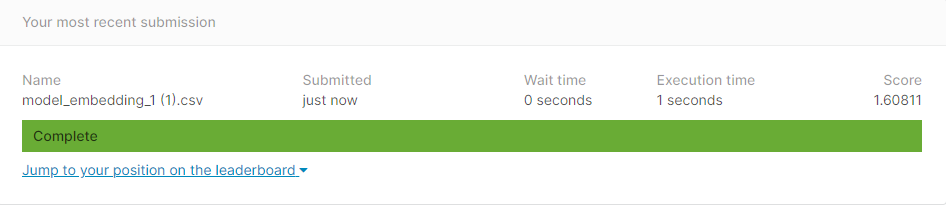

### Improved Categorical Embedding Model - version 1
----

In [ ]:
input_all_items = Input(shape=(1,), dtype='int64')
input_all_shops = Input(shape=(1,), dtype='int64')

shops_shape = get_shape_for_embedding(shops)
items_shape = get_shape_for_embedding(items)

all_items_emb = get_embedding_layer(items_shape,1,1e-5)(input_all_items)
all_shops_emb = get_embedding_layer(shops_shape,1,1e-5)(input_all_shops)


In [ ]:
x =  concatenate([months_emb_cat,shops_emb_cat,cats_emb_cat,items_emb_cat,all_items_emb,all_shops_emb])
x = Flatten()(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(1,activation='relu')(x)

model_embedding_cat_2 = Model([input_month,input_shop,input_category,input_item,input_all_items,input_all_shops],x)
model_embedding_cat_2.compile(loss = 'mse',optimizer='RMSProp', metrics=[RootMeanSquaredError()])
model_embedding_cat_2.summary()

In [ ]:
hist_emb_2 = model_embedding_cat_2.fit([X_train_cat['month'],X_train_cat['shop_id'],X_train_cat['item_category_id'],X_train_cat['item_id'],X_train['sales_item_prev_month'],X_train['sales_shop_prev_month']],
                       y_train,
                       epochs=6,
                       validation_data=[[X_val_cat['month'],X_val_cat['shop_id'],X_val_cat['item_category_id'],X_val_cat['item_id'],X_val['sales_item_prev_month'],X_val['sales_shop_prev_month']],y_val],
                       batch_size = 4096,
                       shuffle=True)

In [ ]:
plot_accuracy_vs_loss(hist_emb_2)
# submitting scores to kaggle
y_test_cat = model_embedding_cat_2.predict([X_test_cat['month'],X_test_cat['shop_id'],X_test_cat['item_category_id'],X_test_cat['item_id'],X_test['sales_item_prev_month'],X_test['sales_shop_prev_month']]).clip(0,20)
index = X_test_cat.index
submit_to_kaggle(index,y_test_cat.ravel(),"model_embedding_2.csv")

### *We got a RMSE score of : 1.09923*
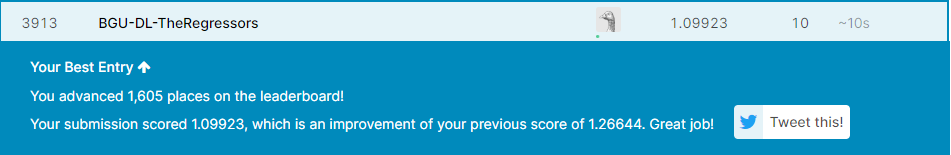

# Insights about the Embeddings
----
### In this section we will look on the weigths of our embedding layers and see some interesting facts about what we got

In [ ]:
def get_euclidean_distance(a,b):
    from scipy.spatial import distance
    return distance.euclidean(a, b)

def get_similar_vectors(vectors,thresh):
    vec_dict = {}
    i=0
    for v1 in vectors:
        similar = []
        j=0
        for v2 in vectors:
            if (v1 != v2).all() and (get_euclidean_distance(v1,v2) < thresh):
                similar.append(j)
            j += 1
        vec_dict[i] = similar
        i += 1
    return vec_dict

In [ ]:
# gets the weights for the items from the embedding layer
item_weights = model_embedding_cat_2.layers[9].get_weights()
# checks which weights are similar
sim = get_similar_vectors(item_weights[0][:1000],0.0001)

In [ ]:
print(items.iloc[0].item_name)
for i in sim[4]:
    print(items.iloc[i].item_name)

### On of the runs of the previous code yeilded the following results:<br>
sim = {0: [4,
  25,
  83,
  104,
  110,
  114,
  124,
  131,
  138,
  139,
  140,
  146,
  147,
  159,
  160,
  162,
  167]}<br><br>
  item_names:<br>! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D<br>
/ТЫ  - ТРУП<br>
12/ДВЕНАДЦАТЬ (СР) (Регион)<br>
1С-Битрикс: Управление сайтом - Старт (Bitrix) [PC, Цифровая версия]<br>
1С:Аудио. Музыка восстановления равновесия души и тела [Цифровая версия]<br>
1С:Аудио. Музыка для снятия стресса [Цифровая версия]<br>
1С:Аудиокниги "Серая Шейка" [Цифровая версия]<br>
1С:Аудиокниги "Сказки. Выпуск 6" [Цифровая версия]<br>
1С:Аудиокниги. А. Некрасов. Приключения капитана Врунгеля (Digipack)<br>
1С:Аудиокниги. А.М. Волков. Волшебник изумрудного города (Digipack)<br>
1С:Аудиокниги. Аладдин и другие восточные сказки (Jewel)<br>
1С:Аудиокниги. Английские неправильные глаголы. Тренажер   [PC, Цифровая версия]<br>
1С:Аудиокниги. Английские пословицы, поговорки и устойчивые выражения. Самоучитель  [PC, Цифровая версия]<br>
1С:Аудиокниги. Английский язык за 12 дней: Самоучитель. Деловой английский  [PC, Цифровая версия]<br>
1С:Аудиокниги. Английский язык за 12 дней: Самоучитель. Отдых за рубежом [PC, Цифровая версия]<br>
1С:Аудиокниги. Андерсен Г.Х. Дюймовочка<br><br>
### Since the labels are in russian an explanation is needed here.<br><br>The first item is a DVD movie, all the other item are CD's and most of them are from the same company label.<br>We can see that our embedding layer gives minmizing distance of weights for items with the same or related categories(see below picture of item 0 and some close item related).

### *Note:<br> 1. We took only 1000 items since this mapping took a long time to run <br> 2. We can do the same procedure for shops and other features of the model to see how are they corrolating*


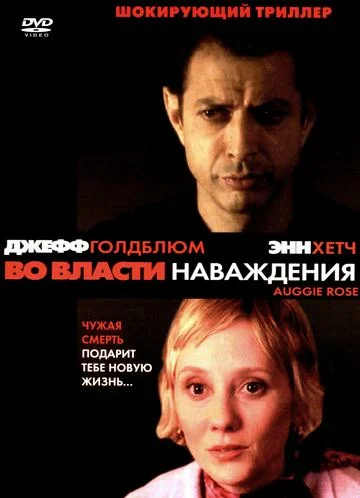

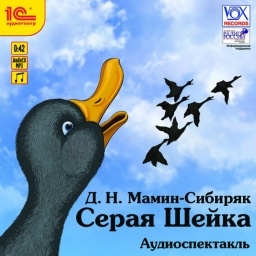

# Using Feature Extraction 
---
### In this section we will use feature extraction from our last model and we will try to use theses features in a classic ML algorithm

In [ ]:
# creating a model using the weights of the previous model
months_emb_cat = get_embedding_layer(months_shape,1,1e-5,is_fe=True,weights=model_embedding_cat_2.layers[6].get_weights())(input_month)
shops_emb_cat = get_embedding_layer(shops_shape,1,1e-5,is_fe=True,weights=model_embedding_cat_2.layers[7].get_weights())(input_shop)
cats_emb_cat = get_embedding_layer(cats_shape,1,1e-5,is_fe=True,weights=model_embedding_cat_2.layers[8].get_weights())(input_category)
items_emb_cat = get_embedding_layer(items_shape,1,1e-5,is_fe=True,weights=model_embedding_cat_2.layers[9].get_weights())(input_item)
all_items_emb = get_embedding_layer(items_shape,1,1e-5,is_fe=True,weights=model_embedding_cat_2.layers[10].get_weights())(input_all_items)
all_shops_emb = get_embedding_layer(shops_shape,1,1e-5,is_fe=True,weights=model_embedding_cat_2.layers[11].get_weights())(input_all_shops)

x =  concatenate([months_emb_cat,shops_emb_cat,cats_emb_cat,items_emb_cat,all_items_emb,all_shops_emb],weights=model_embedding_cat_2.layers[12].get_weights())
x = Flatten(weights=model_embedding_cat_2.layers[13].get_weights())(x)
x = BatchNormalization(weights=model_embedding_cat_2.layers[14].get_weights())(x)

x = Dense(64, activation='relu',weights=model_embedding_cat_2.layers[15].get_weights())(x)
x = Dense(128, activation='relu',weights=model_embedding_cat_2.layers[16].get_weights())(x)
x = Dropout(0.3,weights=model_embedding_cat_2.layers[17].get_weights())(x)
x = Dense(128, activation='relu',weights=model_embedding_cat_2.layers[18].get_weights())(x)
x = Dense(256, activation='relu',weights=model_embedding_cat_2.layers[19].get_weights())(x)
x = Dropout(0.2,weights=model_embedding_cat_2.layers[20].get_weights())(x)

model_fe = Model([input_month,input_shop,input_category,input_item,input_all_items,input_all_shops],x)
model_fe.compile(loss = 'mse',optimizer='RMSProp', metrics=[RootMeanSquaredError()])
model_fe.summary()

In [ ]:
X_fe_emb_train = model_fe.predict([X_train_cat['month'],X_train_cat['shop_id'],X_train_cat['item_category_id'],X_train_cat['item_id'],X_train['sales_item_prev_month'],X_train['sales_shop_prev_month']])
X_fe_emb_val = model_fe.predict([X_val_cat['month'],X_val_cat['shop_id'],X_val_cat['item_category_id'],X_val_cat['item_id'],X_val['sales_item_prev_month'],X_val['sales_shop_prev_month']])

X_fe_emb_train = np.squeeze(X_fe_emb_train)
X_fe_emb_val = np.squeeze(X_fe_emb_val)

In [ ]:
dt = DecisionTreeRegressor()
# fit the model on the train set
dt.fit(X_fe_emb_train,y_train)

# calculate RMSE for our validation data
y_pred_val = dt.predict(X_fe_emb_val)
print("RMSE for validation set is: "+str(rmse(y_val,y_pred_val)))

# submitting scores to kaggle
y_test = dt.predict(X_test).clip(0,20)
index = X_test.index
submit_to_kaggle(index,y_test,"decision_tree_feature_extraction.csv")

### *We got a RMSE score of : 1.49274*

# Conclusions
----
1. We used a DecisionTreeRegressor in order to get a solic benchmark for predicting the sales for next month
2. We improved the results by creating a categoricl embedding model
3. We saw that we can improve our predictions by adding a non-categorical features and creating an extended embedding model
4. We saw that the embeddings tries to minimize the distance between items that are related
5. We used the notion of Feature-Extraction in order to get a solid benchmark of our best embedding model